In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../utility")
from inference import recover_controls_for_trajectory, load_koopman_model
from dataset import KoopmanDatasetCollector
import torch
import pandas as pd

In [12]:
def low_pass_filter(data, window_size=3):
        kernel = np.ones(window_size) / window_size
        filtered = np.zeros_like(data)

        for i in range(data.shape[1]):
            filtered[:, i] = np.convolve(data[:, i], kernel, mode='same')
        return filtered

In [13]:
test_data = np.loadtxt("../data/datasets/kinova_data/output_20250403_104412.txt")
test_data[:, :7] = low_pass_filter(test_data[:, :7], window_size=1000)
torque_data = test_data.reshape(-1, 21)[:20000, :7]
state_data = test_data.reshape(-1, 21)[:20000, 7:21]

Checkpoint keys: dict_keys(['model', 'layer'])


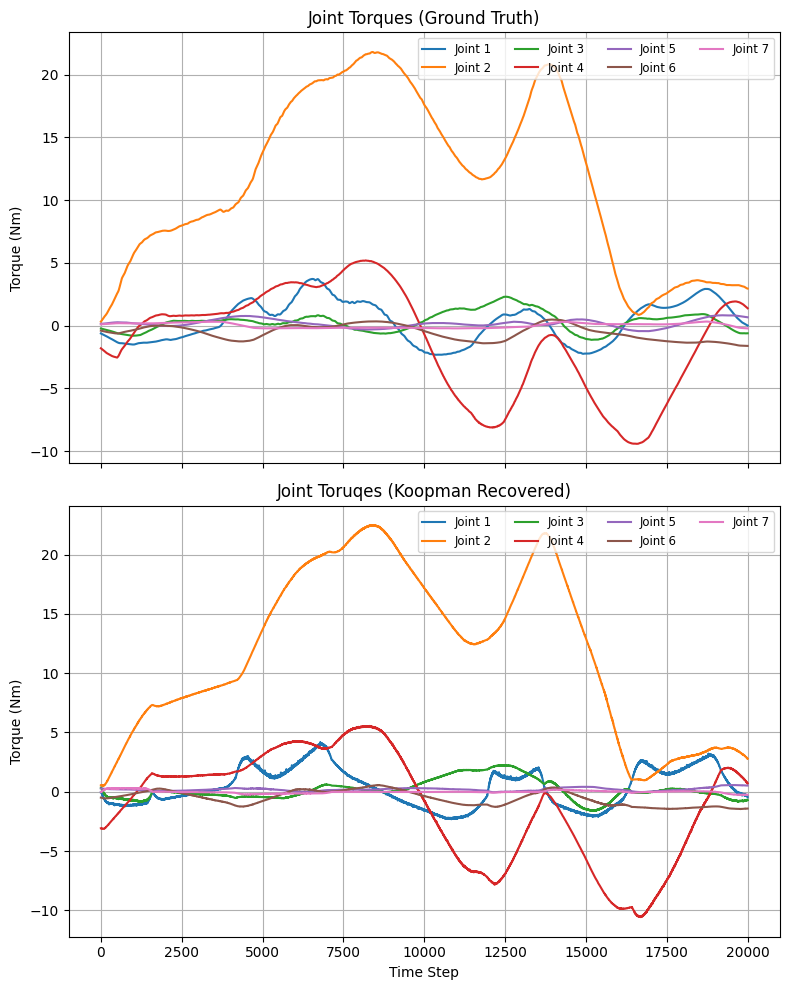

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = load_koopman_model("../log/best_models/Kinova/best_model_unnorm_Kinova_896_1_1_1.pth",device)

koopman_torque_data = recover_controls_for_trajectory(state_data,net,device=device).detach().cpu().numpy()
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
# Plot torques
for i in range(7):
    axs[0].plot(torque_data[:, i], label=f'Joint {i+1}')
axs[0].set_title('Joint Torques (Ground Truth)')
axs[0].set_ylabel('Torque (Nm)')
axs[0].legend(loc='upper right', ncol=4, fontsize='small')
axs[0].grid(True)

# Plot velocities
for i in range(7):
    axs[1].plot(koopman_torque_data[:, i], label=f'Joint {i+1}')
axs[1].set_title('Joint Toruqes (Koopman Recovered)')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Torque (Nm)')
axs[1].legend(loc='upper right', ncol=4, fontsize='small')
axs[1].grid(True)
plt.tight_layout()
plt.show()

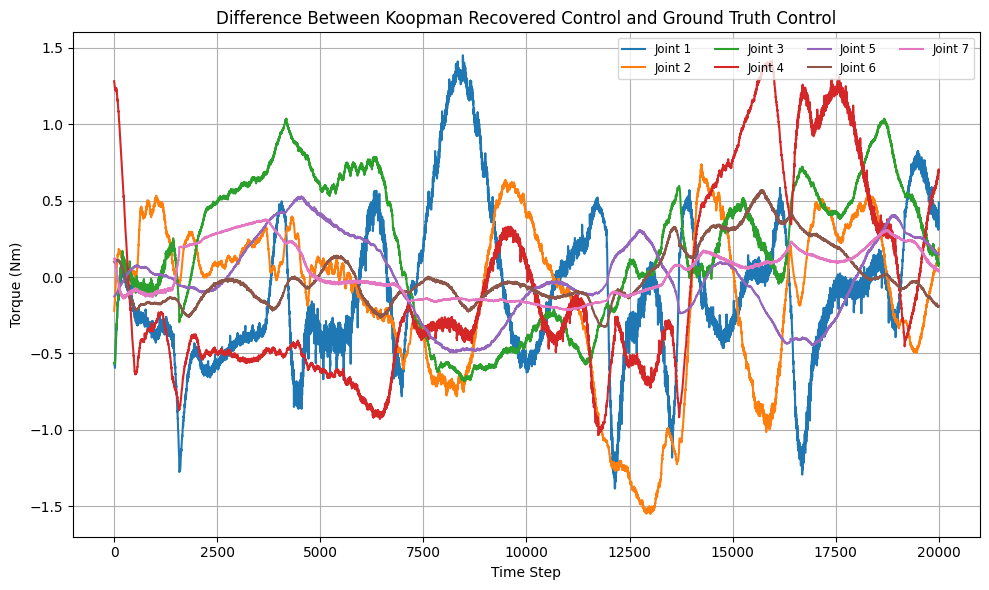

In [34]:
abs_error_data = torque_data[1:,] - koopman_torque_data
plt.figure(figsize=(10, 6))
for i in range(7):
    plt.plot(abs_error_data[:, i], label=f'Joint {i+1}')
plt.title('Difference Between Koopman Recovered Control and Ground Truth Control')
plt.xlabel('Time Step')
plt.ylabel('Torque (Nm)')
plt.legend(loc='upper right', ncol=4, fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()
